In [93]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_theme()

### Meta Data

In this project, we are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud. The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

**Transaction Table**

- **TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAmt**: transaction payment amount in USD
- **ProductCD**: product code, the product for each transaction
- **card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.
- **addr1, addr2**: “both addresses are for purchaser; addr1 as billing region; addr2 as billing country”
- **dist: distance**; "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”
- **P_ and (R__) emaildomain**: purchaser and recipient email domain (certain transactions don't need recipient, so R_emaildomain is null.)
- **C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. (maybe counts of phone numbers, email addresses, names associated with the user, device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.)
- **D1-D15**: timedelta, such as days between previous transaction, etc.
- **M1-M9**: match, such as names on card and address, etc.
- **Vxxx**: Vesta engineered rich features, including ranking, counting, and other entity relations.


**Identity Table**

- **DeviceType**
- **DeviceInfo**
- **id_01 - id_38**
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
- The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement

### Load Data

In [2]:
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"

#Read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)

train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='right')
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]

train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]

print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 590540 rows & 434 columns.


Due to the abundance of transaction data as compared to identity data, we have chosen to utilize transaction data as the primary predictors in our analysis. To achieve this, we have performed a left join on the "TransactionID" column, merging the two dataframes. This merge retains all the records from the transaction dataframe and adds matched records from the identity dataframe. Consequently, our final dataset is a merged dataset containing 590540 rows and 434 columns.

In [3]:
# release data from those four
del train_transaction
del train_identity

In [4]:
train_df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

We observed significantly less fraud data in our dataset. In order to create a model that predicts both class accurately, we decide to balance the labels by downsampling, as oversampling would lead to overfitting. 

In [5]:
train_is_fraud = train_df[train_df['isFraud']==1].sample(replace=False, n=len(train_df[train_df['isFraud']==1]))
train_is_not_fraud = train_df[train_df['isFraud']==0].sample(replace=False, n=len(train_is_fraud))
train_df = pd.concat([train_is_fraud, train_is_not_fraud])

In [6]:
train_df.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

### EDA

Because we have a total of 434 columns, it is difficult to check correlation between each column and the predicted label. Therefore, we used our intuition and domain knowledge to select a subset of features that we thought could be effective in predicting whether or not the transaction is fraudulent.

- Transaction Time

- Transaction Amount

- Card information

- Billing Address

- Email Domains

- Device Type

- Device Info

In [7]:
#Transform TransactionDT into Day, Hour, Day of Week, Month
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

def convert_day_of_month(x):
    return (x // (24 * 60 * 60)) % 31

def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

def convert_month(x):
    return (x // (31 * 24 * 60 * 60)) % 12

In [8]:
#Time offset
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
#Day, Hour, Day of Week, Month conversion
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)
train_df['TransactionDayOfMonth'] = train_df['TransactionDT'].apply(convert_day_of_month)
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionMonth'] = train_df['TransactionDT'].apply(convert_month)

#### Fraud Percentage By Hour

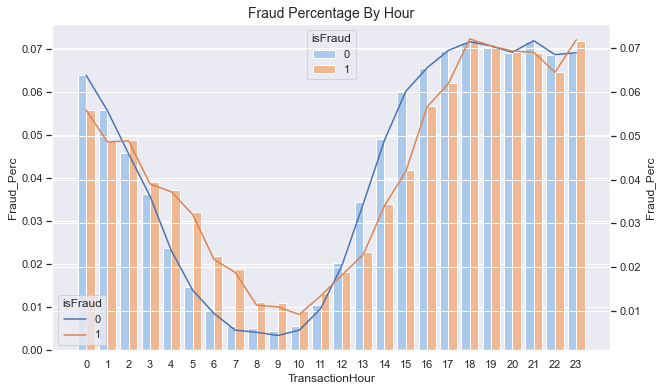

In [9]:
fraud_hour_perc = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionHour'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_hour_perc_df = fraud_hour_perc / fraud_hour_perc.groupby(level=0).sum()
fraud_hour_perc_df = fraud_hour_perc_df.reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Fraud Percentage By Hour', fontsize=14)
ax1 = sns.barplot(x="TransactionHour", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_hour_perc_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionHour', y='Fraud_Perc', data = fraud_hour_perc_df, sort=False, hue="isFraud")
plt.show()

#### Fraud Percentage by Day of Week

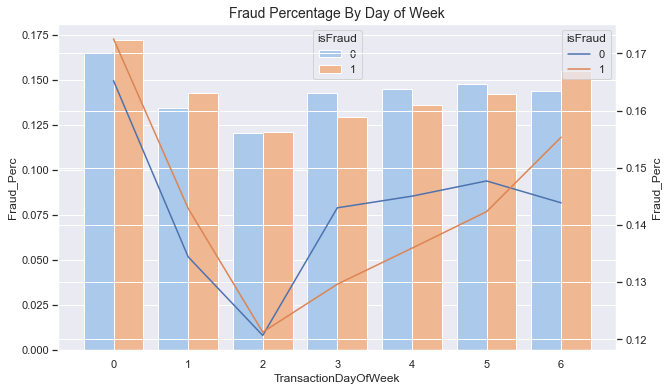

In [10]:
fraud_dow_perc = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionDayOfWeek'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_dow_perc_df = fraud_dow_perc / fraud_dow_perc.groupby(level=0).sum()
fraud_dow_perc_df = fraud_dow_perc_df.reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Fraud Percentage By Day of Week', fontsize=14)
ax1 = sns.barplot(x="TransactionDayOfWeek", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_dow_perc_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionDayOfWeek', y='Fraud_Perc', data = fraud_dow_perc_df, sort=False, hue="isFraud")
plt.show()

#### Fraud Percentage by Month

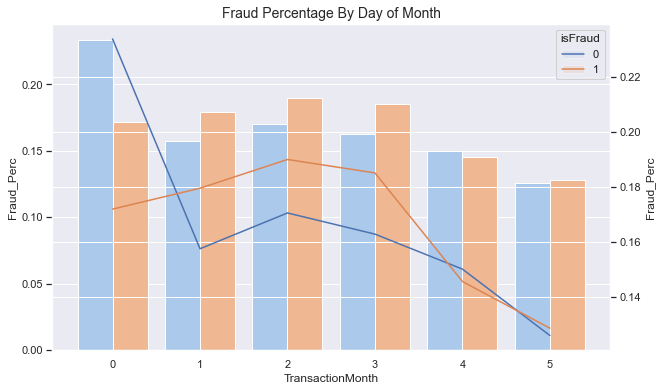

In [11]:
fraud_month_perc = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionMonth'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_month_perc_df = fraud_month_perc / fraud_month_perc.groupby(level=0).sum()
fraud_month_perc_df = fraud_month_perc_df.reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Fraud Percentage By Day of Month', fontsize=14)
ax1 = sns.barplot(x="TransactionMonth", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_month_perc_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionMonth', y='Fraud_Perc', data = fraud_month_perc_df, sort=False, hue="isFraud")
plt.show()

#### Convert to relative timezone

In [12]:
time_df = train_df[['TransactionID', 'isFraud', 'TransactionDT', 'TransactionHour', 'TransactionDayOfMonth', 'TransactionDayOfWeek', 'TransactionMonth', 'id_14']]
time_df = time_df[time_df['id_14'].isnull() == False]
#Converting to time zone
time_df['time_zone'] = time_df['id_14'] / 60
#Set East Time as 0
time_df['time_zone_us_0'] = time_df['time_zone'] + 5
time_df['TransactionDT_local'] = (time_df['TransactionDT'] + time_df['time_zone_us_0'] * 60 * 60)
time_df['TransactionHour_US'] = time_df['TransactionDT_local'].apply(convert_hour)
time_df['TransactionDayOfMonth_US'] = time_df['TransactionDT_local'].apply(convert_day_of_month)
time_df['TransactionDayOfWeek_US'] = time_df['TransactionDT_local'].apply(convert_day_of_week)
time_df = time_df[['isFraud', 'TransactionDT', 'TransactionHour', 'TransactionDayOfMonth', 'TransactionDayOfWeek', 'id_14', 'time_zone_us_0', 'TransactionHour_US']]

In [13]:
table = pd.pivot_table(time_df, values=['isFraud'], index=['TransactionHour_US'],
                    aggfunc={'isFraud': np.mean})
east_time_df = time_df[time_df['time_zone_us_0'] == 0]
west_time_df = time_df[time_df['time_zone_us_0'] == -3]

#### US Eastern Time

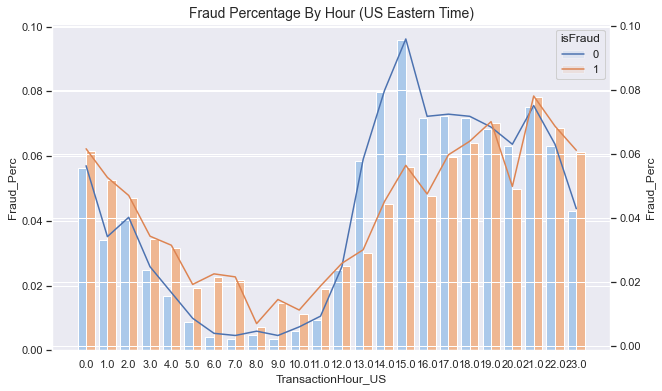

In [14]:
fraud_hour_east = pd.DataFrame(east_time_df.groupby(['isFraud', 'TransactionHour_US'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_hour_east_df = fraud_hour_east / fraud_hour_east.groupby(level=0).sum()
fraud_hour_east_df = fraud_hour_east_df.reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Fraud Percentage By Hour (US Eastern Time)', fontsize=14)
ax1 = sns.barplot(x="TransactionHour_US", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_hour_east_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionHour_US', y='Fraud_Perc', data = fraud_hour_east_df, sort=False, hue="isFraud")
plt.show()

#### US Western Time

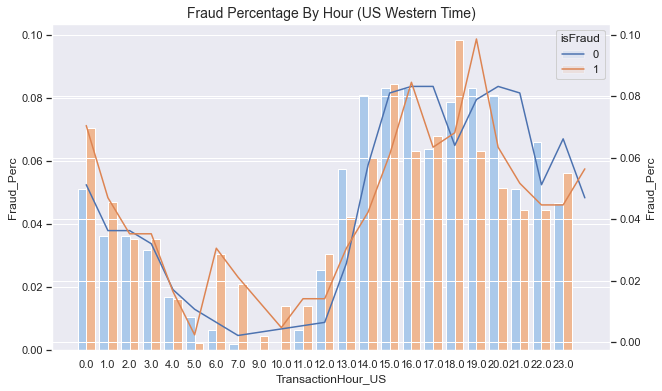

In [15]:
fraud_hour_west = pd.DataFrame(west_time_df.groupby(['isFraud', 'TransactionHour_US'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_hour_west_df = fraud_hour_west / fraud_hour_west.groupby(level=0).sum()
fraud_hour_west_df = fraud_hour_west_df.reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Fraud Percentage By Hour (US Western Time)', fontsize=14)
ax1 = sns.barplot(x="TransactionHour_US", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_hour_west_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionHour_US', y='Fraud_Perc', data = fraud_hour_west_df, sort=False, hue="isFraud")
plt.show()

### Transaction Amount

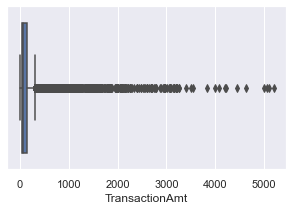

In [16]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.boxplot(train_df['TransactionAmt'])

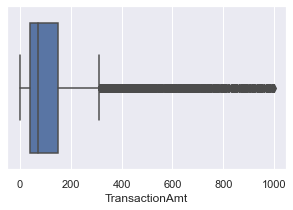

In [17]:
#Remove outliers
fig, ax = plt.subplots(figsize=(5,3))
transaction_amount = train_df[train_df['TransactionAmt'] < 1000]['TransactionAmt']
ax = sns.boxplot(transaction_amount)

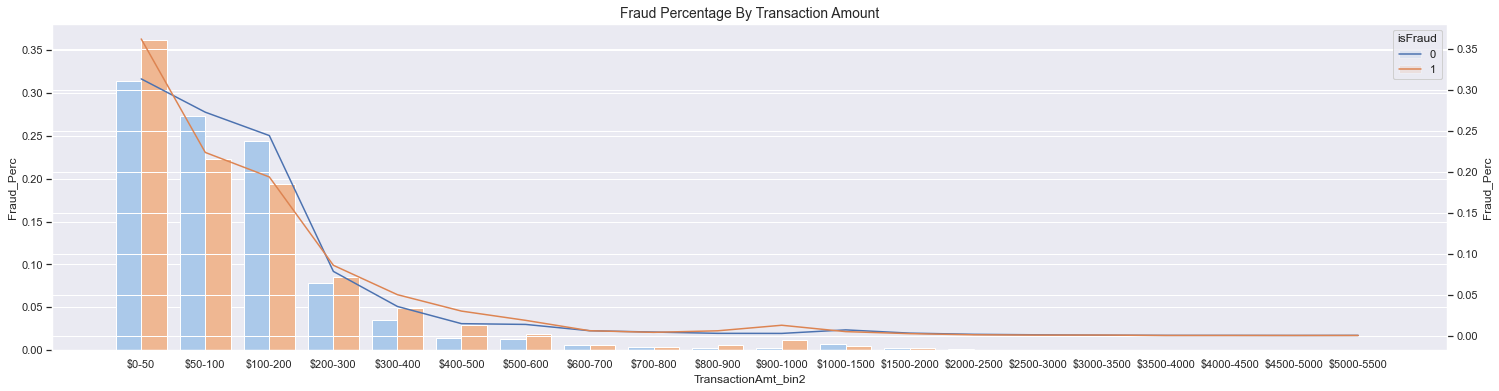

In [18]:
def convert_to_bin_amt(x):
    if x < 50:
        return '$0-50'
    elif x < 100:
        return '$50-100'
    elif x < 200:
        return '$100-200'
    elif x < 300:
        return '$200-300'
    elif x < 400:
        return '$300-400'
    elif x < 500:
        return '$400-500'
    elif x < 600:
        return '$500-600'
    elif x < 700:
        return '$600-700'
    elif x < 800:
        return '$700-800'
    elif x < 900:
        return '$800-900'
    elif x < 1000:
        return '$900-1000'
    elif x < 1500:
        return '$1000-1500'
    elif x < 2000:
        return '$1500-2000'
    elif x < 2500:
        return '$2000-2500'
    elif x < 3000:
        return '$2500-3000'
    elif x < 3500:
        return '$3000-3500'
    elif x < 4000:
        return '$3500-4000'
    elif x < 4500:
        return '$4000-4500'
    elif x < 5000:
        return '$4500-5000'
    elif x < 5500:
        return '$5000-5500'
    elif x < 6000:
        return '$5500-6000'
    elif x < 6500:
        return '$6000-6500'
    elif x < 7000:
        return '$6500-7000'
    elif x < 7500:
        return '$7000-7500'
    elif x < 8000:
        return '$7500-8000'
    elif x < 8500:
        return '$8000-8500'
    elif x < 9000:
        return '$8500-9000'
    elif x < 9500:
        return '$9000-9500'
    elif x < 10000:
        return '$9500-10000'
    else:
        return '$10000-+'
    
train_df['TransactionAmt_bin2'] = train_df['TransactionAmt'].apply(convert_to_bin_amt)
fraud_amount = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionAmt_bin2'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_amount_df = fraud_amount / fraud_amount.groupby(level=0).sum()
fraud_amount_df = fraud_amount_df.reset_index()
fraud_amount_df['index_2'] = fraud_amount_df['TransactionAmt_bin2'].apply(lambda x: float(x.split('-')[0][1:]))
fraud_amount_df = fraud_amount_df.sort_values(by=['index_2'], ascending=True)
fig, ax1 = plt.subplots(figsize=(25,6))
ax1.set_title('Fraud Percentage By Transaction Amount', fontsize=14)
ax1 = sns.barplot(x="TransactionAmt_bin2", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_amount_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionAmt_bin2', y='Fraud_Perc', data=fraud_amount_df, sort=True, hue="isFraud")
plt.show()

### Card information

### Billing Address



### Email Domains



### Device Type



### Device Info

### Data Cleaning

- Check Column dependency
    - Categorical Columns
        - Group by missing or not, check final label distribution
        - Group by missing or not, check other columns distribution
        - Group by column labels, check other columns distribution

- Filling Missing values for quantitative columns 
    - Compute the correlation between other quantitative columns
    - Graph the scatterplot between the two columns
    - Impute with value prediction based on other columns with large correlation (>=75%)
    - Add a categorical column stating null or not

- Filling Missing values for categorical columns 
    - Add null as a column value
    - TBD
    
- One hot encode
- Standadization/normalization
    - Clip outlier values 

- PCA

- Transform TransactionDT into Day, Hour, Day of Week, Month because timedelta records the time from a given reference datetime (not an actual timestamp)

- Transaction Amount

In [19]:
def addr1_transform(x):
    if x in top_ten_addr1:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_ten_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def email_p_transform(x):
    if x in top_twenty_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_twenty_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'

In [20]:
# print(min(train_df['TransactionDT']))
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)

# Transaction Amount (Log)
train_df['TransactionAmt_log'] = train_df['TransactionAmt'].apply(lambda x: np.log(x))

#addr1, addr2
top_ten_addr1 = list(train_df['addr1'].value_counts().index)[:100] #top ten regions
top_ten_addr2 = list(train_df['addr2'].value_counts().index)[:100] #top ten countries
train_df['addr1_new'] = train_df['addr1'].apply(addr1_transform)
train_df['addr2_new'] = train_df['addr2'].apply(addr2_transform)

#Email_Domain
top_twenty_email_p = list(train_df['P_emaildomain'].value_counts().index)[:50] #top ten regions
top_twenty_email_r = list(train_df['R_emaildomain'].value_counts().index)[:50] #top ten countries
train_df['P_emaildomain'].value_counts()
train_df['P_emaildomain_new'] = train_df['P_emaildomain'].apply(email_p_transform)
train_df['R_emaildomain_new'] = train_df['R_emaildomain'].apply(email_r_transform)

In [21]:
#device info
def device_info_transform(x):
    if x in top_device_info:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
top_device_info = list(train_df['DeviceInfo'].value_counts().index)[:100] #top device info
train_df['DeviceInfo_new'] = train_df['DeviceInfo'].apply(device_info_transform)

id_lst = ['id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 
               'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_33']

new_id_lst = [i + '_new' for i in id_lst]

top_i_lst = []

def transform_i(x):
    if x in top_i:
        return str(x)
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
        
for i in id_lst:
    new_col = i + '_new'
    top_i = list(train_df[i].value_counts().index)[:12]
    top_i_lst.append(top_i)
    train_df[new_col] = train_df[i].apply(transform_i)   

In [22]:
for i in id_lst:
    new_col = i + '_new'
    top_i = list(train_df[i].value_counts().index)[:12]
    top_i_lst.append(top_i)
    train_df[new_col] = train_df[i].apply(transform_i)

In [23]:
##V
# Groupby missingness
# Groupby correlation
# Keep the column with the most unique values
v_df = train_df.iloc[:, 95:434]
v_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
491873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
376809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
472663,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
v_miss_df = pd.DataFrame(v_df.isnull().mean())
v_miss_df['col'] = v_miss_df.index
group_by_miss_perc = {}
miss_perc = list(v_miss_df[0])
miss_col = list(v_miss_df['col'])

for i in range(len(miss_perc)):
    if miss_perc[i] not in group_by_miss_perc.keys():
        group_by_miss_perc[miss_perc[i]] = [v_miss_df['col'][i]]
    else:
        group_by_miss_perc[miss_perc[i]].append(v_miss_df['col'][i])
        
miss_keys = list(group_by_miss_perc.keys())
final_col_v = []
for i in range(len(miss_keys)):
    corr = train_df[group_by_miss_perc[miss_keys[i]]].corr()
    group = []
    
    for i in corr.columns:
        sub_group = [i]
        for j in corr.columns:
            if (corr[i][j] > 0.7) and (corr[i][j] < 1):
                sub_group.append(j)
        group.append(sub_group)
    
    for i in group:
        i.sort()
    final_group = []
    
    for i in group:
        if i not in final_group:
            final_group.append(i)
            
    for i in final_group:
        if len(i) != 1:
            temp = {}
            for j in i:
                temp[j] = train_df[j].nunique()
            sorted_temp = sorted(temp.items(), key=lambda item: item[1])
            final_col_v.append(sorted_temp[-1][0])
        else:
            final_col_v.append(i[0])
final_col_v = list(set(final_col_v))
final_col_v.sort()

### Feature Selection / Engineering

### One-Hot Encoding

In [ ]:
# list for one-hot
one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour',
                'ProductCD', 'card4', 'card6', 'addr1_new', 'addr2_new', 'P_emaildomain_new', 'R_emaildomain_new',
               'DeviceInfo_new', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'] + new_id_lst

num_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'dist1', 'dist2', 'TransactionAmt_log'] + final_col_v

to_ohe = train_df[one_hot_lst]
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(to_ohe)
ohe_features = ohe.transform(to_ohe)
cates = pd.DataFrame(ohe_features.toarray())

### Principal Component Analysis

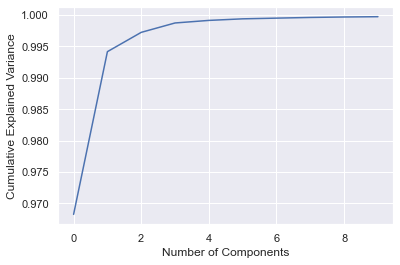

In [91]:
### PCA on numerical variables
pca = PCA(n_components=10)
nums_part = train_df[num_list].reset_index(drop=True)
nums_part = nums_part.fillna(0).replace(-np.Inf, -10).replace(np.Inf, 10)
pca.fit(nums_part)
# Plot the cumulative explained variance as a function of the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
nums_part_pca = pca.transform(nums_part)

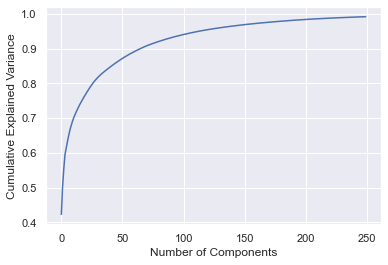

In [94]:
### PCA on categorical variables
pca = PCA(n_components=250)
pca.fit(cates)
# Plot the cumulative explained variance as a function of the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
cates_pca = pca.transform(cates)

In [73]:
# nums_part = train_df[num_list].reset_index(drop=True)

In [100]:
pd.DataFrame(cates_pca)

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,3.640695,-1.969463,1.910955,-1.390545,0.769461,-0.446610,-0.659800,-0.839088,0.550385,0.333643,...,-0.042067,-0.047753,-0.018319,0.063983,0.012262,-0.056999,0.016117,-0.035587,0.026723,0.002888
1,4.489688,3.007578,-0.963227,0.428826,0.443435,-1.443003,-0.490403,0.413367,0.305842,0.012333,...,-0.014681,0.013106,-0.030885,-0.099835,0.030109,-0.012948,0.025007,-0.005314,0.032513,-0.031726
2,-3.145513,-0.063740,-0.802676,-0.904124,0.232280,-0.509196,0.969005,0.235451,-0.486628,0.173113,...,0.019493,0.001394,0.005256,-0.004008,0.000534,0.005447,0.018400,-0.003098,0.001245,-0.001022
3,3.052703,-2.039079,2.056981,-1.181646,-0.210580,1.508995,-0.110625,-0.120262,0.563001,0.229756,...,-0.069281,-0.102657,-0.018025,0.018586,-0.001019,-0.001451,-0.013476,0.032686,0.077650,-0.010557
4,4.738089,-1.841202,-1.193584,0.278024,-0.601637,0.374973,0.599326,-0.790370,-0.517296,-0.031215,...,-0.007387,-0.012814,0.024736,0.011804,0.003499,-0.017666,-0.007625,-0.028376,0.011702,0.006906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41321,4.461713,-2.099512,-1.123909,0.314768,-1.232683,-0.113351,0.584379,-0.192051,1.423673,0.320116,...,-0.008650,-0.010194,0.030692,0.047137,0.004673,-0.029551,0.030963,-0.035878,0.009748,0.002943
41322,-2.731671,0.200691,-0.476548,-0.687195,-0.580308,0.543641,-1.201426,0.577531,0.196881,0.307533,...,-0.001332,0.004113,0.025864,0.020081,0.019263,-0.024116,0.042835,0.065568,-0.041995,0.044228
41323,-3.187195,0.005115,-0.787481,-0.885889,0.323225,-0.499657,0.673852,0.048941,0.425803,0.405122,...,0.001485,-0.004528,0.000037,-0.003731,-0.003492,-0.002064,-0.001419,-0.007585,0.004579,-0.002180
41324,-2.907701,0.166219,-0.756913,-1.098258,-0.526488,0.452581,-0.988493,0.871213,0.143302,0.516341,...,0.004768,0.008869,-0.007117,0.006972,-0.000691,0.003765,0.009735,0.004219,0.001741,0.002469


In [101]:
# X = pd.concat([nums_part, cates], axis=1)
X = pd.concat([pd.DataFrame(nums_part_pca), pd.DataFrame(cates_pca)], axis=1)
y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]
#Raw Ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=590540)
X_train = X_train.fillna(0).replace(-np.Inf, -10).replace(np.Inf, 10)
X_test = X_test.fillna(0).replace(-np.Inf, -10).replace(np.Inf, 10)

### Model Selection

#### Naive Bayes (Baseline Model)

In [102]:
def build_result(X_train, X_test, y_train, y_test, model):
    clf = model
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    return clf, accuracy, X_test, y_test, y_pred, fpr, tpr, auc_score

In [103]:
nb_model = BernoulliNB()
nb_clf, accuracy, X_test, y_test, y_pred, fpr, tpr, auc_score = build_result(X_train, X_test, y_train, y_test, nb_model)
print('Accuracy = ' + str(round(accuracy_score(y_test, y_pred), 3)))
score = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision = ' + str(round(score[0], 3)))
print('Recall = ' + str(round(score[1], 3)))
print('F1 = ' + str(round(score[2], 3)))

Accuracy = 0.711
Precision = 0.696
Recall = 0.749
F1 = 0.721


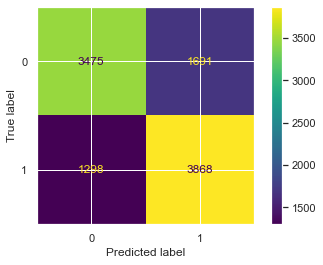

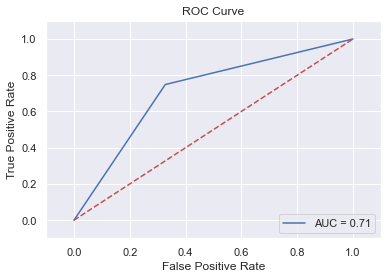

In [104]:
plot_confusion_matrix(nb_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

#### Random Forest

In [105]:
rf_model = RandomForestClassifier(random_state=42)
rf_clf, accuracy, X_test, y_test, y_pred, fpr, tpr, auc_score = build_result(X_train, X_test, y_train, y_test, rf_model)
print('Accuracy = ' + str(round(accuracy_score(y_test, y_pred), 3)))
score = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision = ' + str(round(score[0], 3)))
print('Recall = ' + str(round(score[1], 3)))
print('F1 = ' + str(round(score[2], 3)))

Accuracy = 0.813
Precision = 0.825
Recall = 0.795
F1 = 0.81


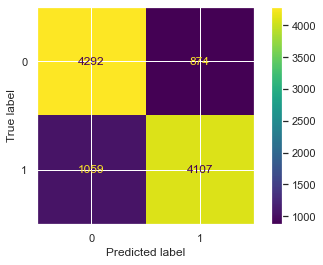

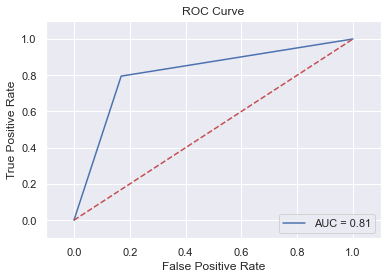

In [106]:
plot_confusion_matrix(rf_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

#### LightGBM

In [107]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_clf, accuracy, X_test, y_test, y_pred, fpr, tpr, auc_score = build_result(X_train, X_test, y_train, y_test, lgb_model)
print('Accuracy = ' + str(round(accuracy_score(y_test, y_pred), 3)))
score = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision = ' + str(round(score[0], 3)))
print('Recall = ' + str(round(score[1], 3)))
print('F1 = ' + str(round(score[2], 3)))

Accuracy = 0.809
Precision = 0.823
Recall = 0.786
F1 = 0.804


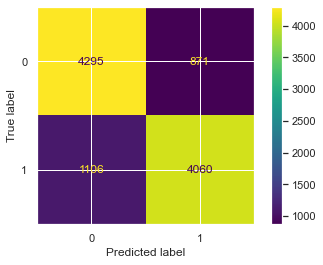

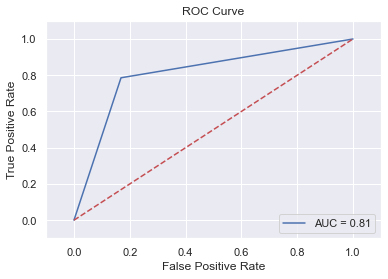

In [108]:
plot_confusion_matrix(lgb_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

#### XGBoost

In [109]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_clf, accuracy, X_test, y_test, y_pred, fpr, tpr, auc_score = build_result(X_train, X_test, y_train, y_test, xgb_model)
print('Accuracy = ' + str(round(accuracy_score(y_test, y_pred), 3)))
score = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Precision = ' + str(round(score[0], 3)))
print('Recall = ' + str(round(score[1], 3)))
print('F1 = ' + str(round(score[2], 3)))

Accuracy = 0.815
Precision = 0.827
Recall = 0.796
F1 = 0.811


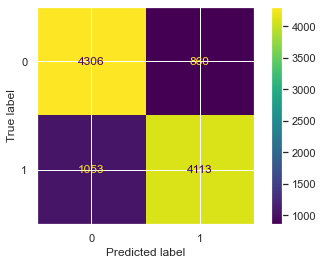

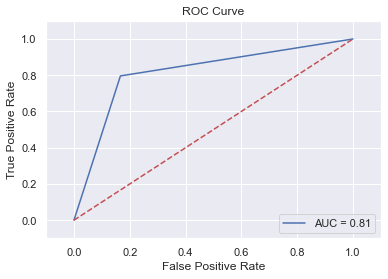

In [110]:
plot_confusion_matrix(xgb_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Results